In [0]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.631899,0.975693,00:00
1,0.854341,0.669287,00:00
2,0.644917,0.662991,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [9]:
path=Config.data_path()/'ml-100k'
path

PosixPath('/root/.fastai/data/ml-100k')

In [11]:
! wget  http://files.grouplens.org/datasets/movielens/ml-100k.zip

--2020-01-05 01:40:51--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.52MB/s    in 0.9s    

2020-01-05 01:40:52 (5.52 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [12]:
! unzip /content/ml-100k.zip

Archive:  /content/ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
!mv /content/ml-100k /root/.fastai/data/ml-100k

In [56]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [15]:
len(ratings)

6031

In [16]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,73,1097,4.0,1255504951,"Hate (Haine, La) (1995)"
1,102,1097,4.0,956600083,"Hate (Haine, La) (1995)"
2,665,1097,5.0,992909039,"Hate (Haine, La) (1995)"
3,157,1097,3.0,1291598808,"Hate (Haine, La) (1995)"
4,312,1097,3.0,959935483,"Hate (Haine, La) (1995)"


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [0]:
data.show_batch()

userId,title,target
126,Event Horizon (1997),1.0
44,Young Frankenstein (1974),4.0
718,Star Trek: First Contact (1996),4.0
506,"Magnificent Seven, The (1954)",5.0
373,"Good, The Bad and The Ugly, The (1966)",3.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


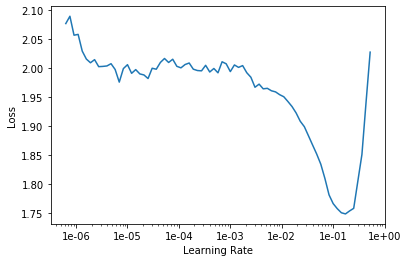

In [20]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [21]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.860829,1.644978,00:00
1,1.089733,0.585952,00:00
2,0.725589,0.560570,00:00
3,0.587215,0.564699,00:00
4,0.528267,0.563726,00:00


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [25]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(100, 40)
  (i_weight): Embedding(71, 40)
  (u_bias): Embedding(100, 1)
  (i_bias): Embedding(71, 1)
)

In [26]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Client, The (1994)', 'Life with Mikey (1993)', 'Promesse, La (1996)', 'Event Horizon (1997)',
       'North by Northwest (1959)', 'Stalingrad (1993)', 'Liebelei (1933)', 'Star Maps (1997)',
       'Savage Nights (Nuits fauves, Les) (1992)', "Schindler's List (1993)"], dtype=object)

### Movie bias

In [27]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([70])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [30]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.0662), 'Fish Called Wanda, A (1988)', 2.411111111111111),
 (tensor(-0.0328), 'Batman Returns (1992)', 2.836734693877551),
 (tensor(-0.0168), 'Clueless (1995)', 2.9545454545454546),
 (tensor(-0.0071), 'Apostle, The (1997)', 2.6160714285714284),
 (tensor(-0.0062), 'Fly Away Home (1996)', 3.189655172413793),
 (tensor(-0.0006), 'Hour of the Pig, The (1993)', 3.0980392156862746),
 (tensor(0.0002), 'Terminal Velocity (1994)', 3.0357142857142856),
 (tensor(0.0323), 'Liebelei (1933)', 3.4358974358974357),
 (tensor(0.0348), 'Doom Generation, The (1995)', 3.443396226415094),
 (tensor(0.0390), 'Hellraiser: Bloodline (1996)', 3.5636363636363635),
 (tensor(0.0415), 'Strange Days (1995)', 3.40625),
 (tensor(0.0443), 'Shadowlands (1993)', 3.0673076923076925),
 (tensor(0.0501), 'Quiet Man, The (1952)', 3.3706896551724137),
 (tensor(0.0560), 'Jean de Florette (1986)', 3.409090909090909),
 (tensor(0.0565), 'Mouse Hunt (1997)', 3.295918367346939)]

In [31]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.1827), 'Amityville: Dollhouse (1996)', 4.484848484848484),
 (tensor(0.1799), "Schindler's List (1993)", 4.331081081081081),
 (tensor(0.1787), 'Virtuosity (1995)', 4.176056338028169),
 (tensor(0.1774), 'When a Man Loves a Woman (1994)', 4.458333333333333),
 (tensor(0.1760), 'Promesse, La (1996)', 4.475609756097561),
 (tensor(0.1688), 'Wild Bunch, The (1969)', 3.962121212121212),
 (tensor(0.1636),
  'Savage Nights (Nuits fauves, Les) (1992)',
  4.2727272727272725),
 (tensor(0.1632), 'Event Horizon (1997)', 4.25625),
 (tensor(0.1625), 'Star Wars (1977)', 4.359649122807017),
 (tensor(0.1606), 'Family Thing, A (1996)', 4.241666666666666),
 (tensor(0.1517), 'Gandhi (1982)', 4.2890625),
 (tensor(0.1504), 'Ed Wood (1994)', 4.125),
 (tensor(0.1469), 'Guilty as Sin (1993)', 4.241666666666666),
 (tensor(0.1465), 'Fan, The (1996)', 3.92),
 (tensor(0.1460), 'Ghosts of Mississippi (1996)', 4.2063492063492065)]

### Movie weights

In [32]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([70, 40])

In [33]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([70, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [35]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9985), 'Promesse, La (1996)'),
 (tensor(0.9331), 'Amityville: Dollhouse (1996)'),
 (tensor(0.7705), 'When a Man Loves a Woman (1994)'),
 (tensor(0.6931), 'Star Wars (1977)'),
 (tensor(0.6369), 'Don Juan DeMarco (1995)'),
 (tensor(0.6287), 'Hugo Pool (1997)'),
 (tensor(0.6240), 'Spellbound (1945)'),
 (tensor(0.6209), 'Guilty as Sin (1993)'),
 (tensor(0.6195), 'Ghosts of Mississippi (1996)'),
 (tensor(0.6173), 'Before the Rain (Pred dozhdot) (1994)')]

In [36]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1623), 'Fish Called Wanda, A (1988)'),
 (tensor(-0.9643), 'Apostle, The (1997)'),
 (tensor(-0.9092), 'Shadowlands (1993)'),
 (tensor(-0.8550), 'Dumb & Dumber (1994)'),
 (tensor(-0.7866), 'Terminal Velocity (1994)'),
 (tensor(-0.7238), 'Eraser (1996)'),
 (tensor(-0.7110), 'Clueless (1995)'),
 (tensor(-0.6536), 'Fly Away Home (1996)'),
 (tensor(-0.6419), 'Mouse Hunt (1997)'),
 (tensor(-0.5672), 'Hour of the Pig, The (1993)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [38]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.5986), 'Batman Returns (1992)'),
 (tensor(0.5652), 'White Squall (1996)'),
 (tensor(0.5647), 'Amos & Andrew (1993)'),
 (tensor(0.3524), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(0.3255), 'Star Maps (1997)'),
 (tensor(0.3056), 'Fish Called Wanda, A (1988)'),
 (tensor(0.2906), 'Mortal Kombat (1995)'),
 (tensor(0.2647), 'Apostle, The (1997)'),
 (tensor(0.2422), 'Spellbound (1945)'),
 (tensor(0.2190), 'Speed 2: Cruise Control (1997)')]

In [39]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.4942), 'Purple Noon (1960)'),
 (tensor(-0.4528), 'Event Horizon (1997)'),
 (tensor(-0.4017), 'Beauty and the Beast (1991)'),
 (tensor(-0.3666), 'Gandhi (1982)'),
 (tensor(-0.3655), "Schindler's List (1993)"),
 (tensor(-0.3588), 'When a Man Loves a Woman (1994)'),
 (tensor(-0.3274), 'Savage Nights (Nuits fauves, Les) (1992)'),
 (tensor(-0.3056), 'Ace Ventura: When Nature Calls (1995)'),
 (tensor(-0.2994), 'Dumb & Dumber (1994)'),
 (tensor(-0.2991), 'Swingers (1996)')]

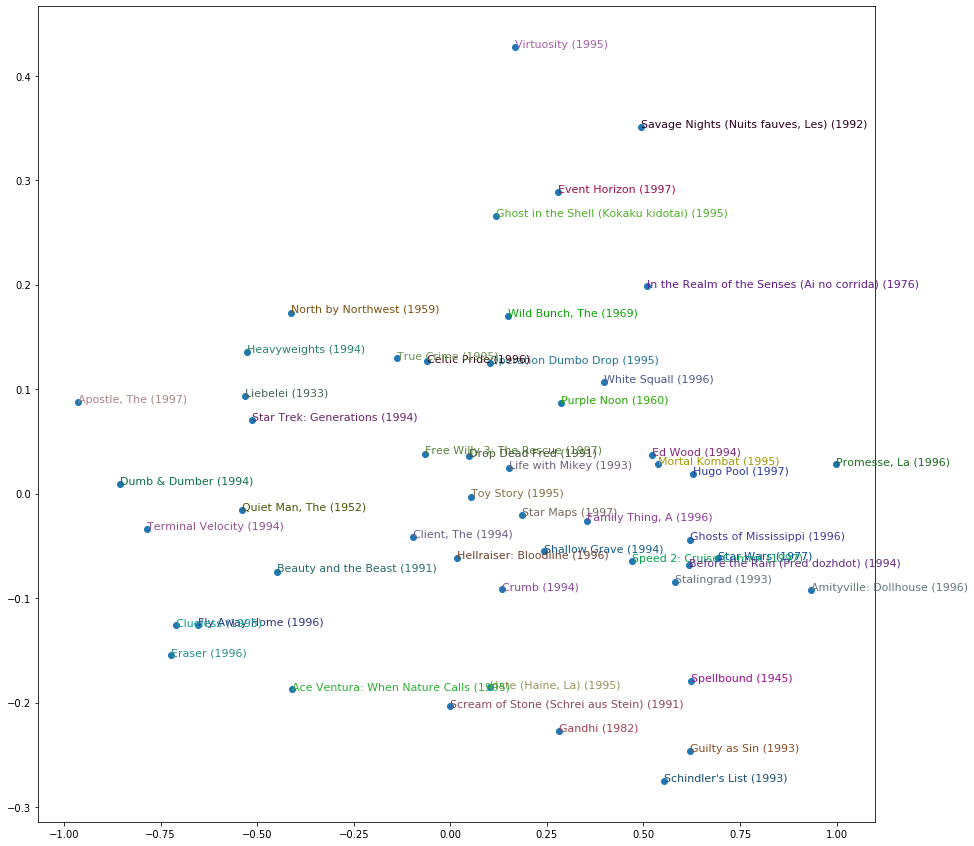

In [40]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()